In [ ]:
# This is a copy of kaggle notebook "https://www.kaggle.com/code/andrewauau/notebook5f1ef0ecda" made by my team in the competition "https://www.kaggle.com/competitions/amex-default-prediction/"

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


In [ ]:
# Step 1: Sample ~2,000,000 rows from training data with complete labels (Balanced dataset)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import numpy as np


# PARQUET_DATA_DIR = "drive/MyDrive/train_data_parquet"
# PARQUET_LABEL_DIR = "drive/MyDrive/train_labels_parquet"

# PARQUET_DATA_DIR = "train_data_parquet"
# PARQUET_LABEL_DIR = "train_labels_parquet"

TRAIN_DATA_PATH = '/kaggle/input/amex-default-prediction/train_data.csv'
TRAIN_LABELS_PATH = '/kaggle/input/amex-default-prediction/train_labels.csv'

print("Loading labels...")
# df_labels = dd.read_parquet(PARQUET_LABEL_DIR, engine="pyarrow").compute()
df_labels = pd.read_csv(TRAIN_LABELS_PATH)

print("Label distribution:")
print(df_labels["target"].value_counts())

# separate counts based on target
n_default = df_labels["target"].sum() # target=1 is default
n_nondefault = len(df_labels) - n_default

print(f"Default customers: {n_default:,}")
print(f"Non-default customers: {n_nondefault:,}")

# calculate average rows per customer
print("Loading small subset to estimate rows per customer...")
# df_train_dask = dd.read_parquet(PARQUET_DATA_DIR, engine="pyarrow")
df_train_dask = dd.read_csv(TRAIN_DATA_PATH)
rows_per_customer_est = int(df_train_dask.shape[0].compute() / len(df_labels))
print(f"Estimated rows per customer: {rows_per_customer_est}")

# 2 million rows max
target_rows = 2_000_000
max_customers_total = target_rows // rows_per_customer_est
max_customers_each_class = max_customers_total // 2

frac_default = max_customers_each_class / n_default
frac_nondefault = max_customers_each_class / n_nondefault

print(f"Sampling {max_customers_each_class:,} customers from each class")

# randomly sample customers
default_customers = df_labels[df_labels["target"] == 1].sample(
    frac=frac_default, random_state=42
)
nondefault_customers = df_labels[df_labels["target"] == 0].sample(
    frac=frac_nondefault, random_state=42
)

# combine sampled customers
sampled_customers = pd.concat([default_customers, nondefault_customers])
sampled_customer_list = sampled_customers["customer_ID"].tolist()

print("Filtering training data to sampled customers...")
df_train_sample = df_train_dask[
    df_train_dask["customer_ID"].isin(sampled_customer_list)
].compute()

print(f"Loaded {len(df_train_sample):,} rows for sampled customers")

# if larger than 2 million rows, randomly sample down to 2 million
if len(df_train_sample) > 2_000_000:
    df_train_sample = df_train_sample.sample(n=2_000_000, random_state=42)

# combine with labels
df_sample = pd.merge(df_train_sample, df_labels, on="customer_ID", how="left")

# check results
print("\nSampling done!")
print(f"Shape: {df_sample.shape}")
print(f"Unique customers: {df_sample['customer_ID'].nunique()}")
print(df_sample["target"].value_counts(normalize=True))


Loading labels...
Label distribution:
target
0    340085
1    118828
Name: count, dtype: int64
Default customers: 118,828
Non-default customers: 340,085
Loading small subset to estimate rows per customer...
Estimated rows per customer: 12
Sampling 83,333 customers from each class
Filtering training data to sampled customers...
Loaded 1,985,064 rows for sampled customers

Sampling done!
Shape: (1985064, 191)
Unique customers: 166666
target
0    0.513195
1    0.486805
Name: proportion, dtype: float64


In [ ]:
# Step 2 Final check
train_data_sampled = df_sample

# for later use, convert to normal pandas DataFrame (not pyarrow type)
train_data_sampled = train_data_sampled.convert_dtypes(dtype_backend="numpy_nullable").infer_objects()

print(type( train_data_sampled ))

display(train_data_sampled.head())


<class 'pandas.core.frame.DataFrame'>


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,<NA>,<NA>,0.002427,0.003706,0.003818,<NA>,0.000569,0.00061,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.12675,0.000798,0.002714,...,<NA>,<NA>,0.003954,0.003167,0.005032,<NA>,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.95418,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,<NA>,<NA>,0.003269,0.007329,0.000427,<NA>,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.0027,0.001373,0.117169,0.000685,0.005531,...,<NA>,<NA>,0.006117,0.004516,0.0032,<NA>,0.008419,0.006527,0.0096,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,<NA>,<NA>,0.003671,0.004946,0.008889,<NA>,0.00167,0.008126,0.009827,0


In [ ]:
# Step 3: Data Cleaning

print("\nShowing missing value percentages for top 20 columns...")
missing_values_perc = (train_data_sampled.isnull().sum() / len(train_data_sampled)) * 100
missing_top20 = missing_values_perc.sort_values(ascending=False).head(20)
display(missing_top20)

print("Starting data cleaning...")

# ensure date columns are in datetime format
if "S_2" in train_data_sampled.columns:
    train_data_sampled["S_2"] = pd.to_datetime(train_data_sampled["S_2"], errors="coerce")

# separate numeric and string columns
num_cols = train_data_sampled.select_dtypes(include=["number"]).columns
str_cols = train_data_sampled.select_dtypes(include=["string", "object"]).columns

print(f"Original rows: {len(train_data_sampled.columns)}")

# remove columns with more than 40% missing data
cols_to_drop = missing_values_perc[missing_values_perc > 40].index.tolist()
train_data_sampled = train_data_sampled.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with more than 40% missing data.")

# delete any "unnamed" columns if exist
drop_cols = [c for c in train_data_sampled.columns if "unnamed" in c.lower()]
train_data_sampled = train_data_sampled.drop(columns=drop_cols, errors="ignore")

print("Finished data cleaning!")
print(f"Rows left: {len(train_data_sampled.columns)}")



Showing missing value percentages for top 20 columns...


D_87     99.873304
D_88     99.814918
D_108    99.363345
D_110    99.202746
D_111    99.202746
B_39     99.154385
B_42     98.926886
D_73     98.807343
D_138    94.951196
D_134    94.951196
D_136    94.951196
D_135    94.951196
D_137    94.951196
B_29     93.399004
R_9      91.969680
D_76     90.832588
D_66     89.585827
D_106    86.516405
D_132    86.490763
D_49     86.413536
dtype: float64

Starting data cleaning...
Original rows: 191
Dropped 31 columns with more than 40% missing data.
Finished data cleaning!
Rows left: 160


In [ ]:
# Step 4: Feature Engineering

print("Beginning feature engineering...")

# sort by customer_ID and date for time series processing
train_data_sampled = train_data_sampled.sort_values(['customer_ID', 'S_2']).reset_index(drop=True)

# data types of numeric columns
num_cols = train_data_sampled.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [c for c in num_cols if c not in ['target']]  # exclude target column

# calculate customer-level aggregate features for numeric columns
agg_funcs = ['mean', 'max', 'min', 'last']
customer_features = (
    train_data_sampled
    .groupby('customer_ID')[num_cols]
    .agg(agg_funcs)
)

# flatten multi-level columns
customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]

# combine target
customer_features = customer_features.merge(
    train_data_sampled[['customer_ID', 'target']].drop_duplicates(),
    on='customer_ID', how='left'
)

print("Finished feature engineering!")
display(customer_features.head())

Beginning feature engineering...
Finished feature engineering!


,customer_ID,P_2_mean,P_2_max,P_2_min,P_2_last,D_39_mean,D_39_max,D_39_min,D_39_last,B_1_mean,...,D_143_last,D_144_mean,D_144_max,D_144_min,D_144_last,D_145_mean,D_145_max,D_145_min,D_145_last,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933824,0.960384,0.86858,0.934745,0.010704,0.091505,0.001082,0.009119,0.012007,...,0.00581,0.005283,0.009616,0.00061,0.00297,0.005814,0.009827,0.000995,0.008533,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878454,0.904482,0.79767,0.880875,0.004181,0.009704,0.000802,0.009704,0.004386,...,0.002202,0.005113,0.009415,0.000129,0.000834,0.0045,0.006932,0.000443,0.003444,0
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0.444606,0.560474,0.328983,0.477116,0.010394,0.038574,0.000467,0.000467,0.070828,...,0.00979,0.005719,0.00977,0.001686,0.003703,0.005654,0.009131,0.001265,0.006274,0
3,0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...,1.005816,1.009762,1.000488,1.009762,0.35344,0.560899,0.000811,0.006181,0.062956,...,0.00117,0.005935,0.009453,0.00205,0.00335,0.005734,0.009967,0.000675,0.000675,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,0.406705,0.424624,0.391495,0.424624,0.124733,0.647319,0.000269,0.531173,0.938564,...,1.005212,0.005054,0.009371,0.000765,0.00335,0.739022,0.824853,0.727649,0.734467,1


After dropping missing values: 105339 rows left, 622 columns.
Summary statistics for numeric columns


,count,mean,std,min,25%,50%,75%,max
P_2_mean,105339.0,0.524051,0.239412,-0.282115,0.351312,0.495987,0.707054,1.007318
P_2_max,105339.0,0.614226,0.217864,-0.231921,0.451392,0.589492,0.788514,1.01
P_2_min,105339.0,0.420465,0.278379,-0.440337,0.23251,0.404982,0.627234,1.003341
P_2_last,105339.0,0.484511,0.28548,-0.402519,0.289027,0.469339,0.709458,1.009996
D_39_mean,105339.0,0.201965,0.175011,0.001683,0.075348,0.163983,0.281671,3.802712
...,...,...,...,...,...,...,...,...
D_145_mean,105339.0,0.086496,0.23201,0.000078,0.004633,0.005346,0.006941,3.970627
D_145_max,105339.0,0.097799,0.246565,0.000078,0.009136,0.009667,0.009991,4.008294
D_145_min,105339.0,0.07544,0.222147,0.0,0.000315,0.000819,0.002568,3.913
D_145_last,105339.0,0.086868,0.236267,0.0,0.003243,0.006491,0.009745,4.001607



Listing missing value percentages for top 20 columns...


customer_ID    0.0
D_92_mean      0.0
R_23_max       0.0
R_23_min       0.0
R_23_last      0.0
D_91_mean      0.0
D_91_max       0.0
D_91_min       0.0
D_91_last      0.0
D_92_max       0.0
D_94_min       0.0
D_92_min       0.0
D_92_last      0.0
D_93_mean      0.0
D_93_max       0.0
D_93_min       0.0
D_93_last      0.0
D_94_mean      0.0
R_23_mean      0.0
R_22_last      0.0
dtype: float64

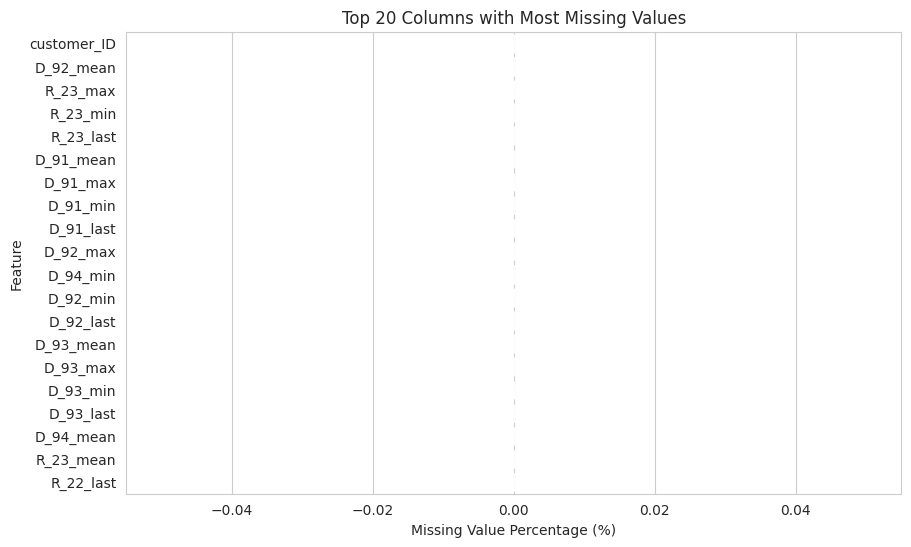


Target variable distribution (per unique customer)


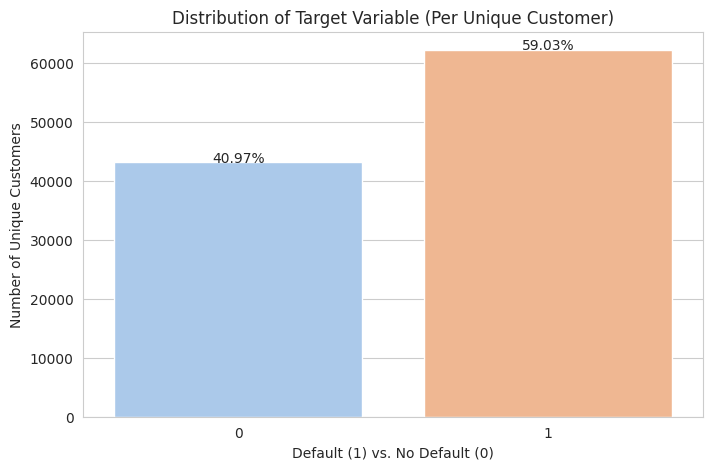


Key categorical feature count plots


In [ ]:
# Step 5: Exploratory Data Analysis (EDA)

# use a cleaner visual theme
sns.set_style('whitegrid')

# current working DataFrame
df = customer_features.dropna().reset_index(drop=True)

print(f"After dropping missing values: {len(df)} rows left, {len(df.columns)} columns.")

# change to parquet
df.to_parquet("cleaned_data.parquet", index=False)

print("Summary statistics for numeric columns")
display(df.describe().T)

print("\nListing missing value percentages for top 20 columns...")
missing_values_perc = (df.isnull().sum() / len(df)) * 100
missing_top20 = missing_values_perc.sort_values(ascending=False).head(20)
display(missing_top20)

plt.figure(figsize=(10,6))
sns.barplot(x=missing_top20.values, y=missing_top20.index, palette='viridis')
plt.title("Top 20 Columns with Most Missing Values")
plt.xlabel("Missing Value Percentage (%)")
plt.ylabel("Feature")
plt.show()

print("\nTarget variable distribution (per unique customer)")

unique_customers = df.drop_duplicates(subset=['customer_ID'])
plt.figure(figsize=(8,5))
sns.countplot(x='target', data=unique_customers, palette='pastel')
plt.title('Distribution of Target Variable (Per Unique Customer)')
plt.xlabel('Default (1) vs. No Default (0)')
plt.ylabel('Number of Unique Customers')

# show percentage on top of bars
total = len(unique_customers)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(
        p.get_x() + p.get_width()/2., height + 50,
        f'{100*height/total:.2f}%', ha='center', fontsize=10
    )
plt.show()

print("\nKey categorical feature count plots")
key_cat_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_68']

for col in key_cat_features:
    if col in df.columns:
        plt.figure(figsize=(10,5))
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, palette='coolwarm')
        plt.title(f'Count Plot for {col}')
        plt.xscale('log')  # use log scale for better visibility
        plt.show()


In [ ]:
# Step 6: Loading test data
import pandas as pd
import os
import pyarrow.parquet as pq
import pyarrow as pa

# Clean up old parquet dirs if exist
os.system("rm -rf test_data_parquet1")
os.makedirs("test_data_parquet1", exist_ok=True)

TEST_DATA_DIR = '/kaggle/input/amex-default-prediction/test_data.csv'

# separatedly load csv and transfer to parquet
chunksize = 500_000  # 500k rows per chunk
i = 0
for chunk in pd.read_csv(TEST_DATA_DIR, chunksize=chunksize):
    table = pa.Table.from_pandas(chunk)
    pq.write_table(table, f"test_data_parquet1/part_{i}.parquet", compression="snappy")
    i += 1
    print(f"✅ Wrote data chunk {i}")


print("💾 All train set CSV chunks saved as parquet successfully!")


✅ Wrote data chunk 1
✅ Wrote data chunk 2
✅ Wrote data chunk 3
✅ Wrote data chunk 4
✅ Wrote data chunk 5
✅ Wrote data chunk 6
✅ Wrote data chunk 7
✅ Wrote data chunk 8
✅ Wrote data chunk 9
✅ Wrote data chunk 10
✅ Wrote data chunk 11
✅ Wrote data chunk 12
✅ Wrote data chunk 13
✅ Wrote data chunk 14
✅ Wrote data chunk 15
✅ Wrote data chunk 16
✅ Wrote data chunk 17
✅ Wrote data chunk 18
✅ Wrote data chunk 19
✅ Wrote data chunk 20
✅ Wrote data chunk 21
✅ Wrote data chunk 22
✅ Wrote data chunk 23
💾 All train set CSV chunks saved as parquet successfully!


In [ ]:
# Step 7: Test data preparation
import dask.dataframe as dd
import pandas as pd
import numpy as np
import gc
import os
import shutil

PARQUET_TEST = "/kaggle/working/test_data_parquet1"
OUTPUT_FILE = "/kaggle/working/cleaned_test_data.parquet"

print("📥 Loading metadata...")
df_meta = dd.read_parquet(PARQUET_TEST, engine="pyarrow")
nparts = df_meta.npartitions
print(f"Found {nparts} partitions")

agg_funcs = ["mean", "max", "min", "last"]

# Detect columns to drop
sample = df_meta.get_partition(0).head(10_000, compute=True)
cols_to_drop = sample.columns[sample.isnull().mean() > 0.4].tolist()
print(f"Dropping {len(cols_to_drop)} high-missing columns")

df_final = []

for i in range(nparts):
    print(f"\n🧩 Processing partition {i+1}/{nparts}")
    df = df_meta.get_partition(i).compute()
    df = df.drop(columns=cols_to_drop, errors="ignore")

    if "S_2" in df.columns:
        df["S_2"] = pd.to_datetime(df["S_2"], errors="coerce")
    df = df.sort_values(["customer_ID", "S_2"])

    # Downcast numeric
    for col in df.select_dtypes("float64"):
        df[col] = df[col].astype("float32")
    for col in df.select_dtypes("int64"):
        df[col] = df[col].astype("int32")

    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if "target" in num_cols:
        num_cols.remove("target")

    # Aggregate within this partition
    part_agg = df.groupby("customer_ID")[num_cols].agg(agg_funcs)
    part_agg.columns = ["_".join(c) for c in part_agg.columns.to_flat_index()]
    df_final.append(part_agg)

    # Clean up memory
    del df, part_agg
    gc.collect()

print("\n🔗 Combining partial results...")
df_all = pd.concat(df_final)
del df_final
gc.collect()

df_final = df_all.groupby("customer_ID").agg("last")
del df_all
gc.collect()

# Remove any old copy before writing
if os.path.exists(OUTPUT_FILE):
    os.remove(OUTPUT_FILE)

OLD_DIR = "/kaggle/working/agg_partitions"

if os.path.exists(OLD_DIR):
    print(f"🧹 Removing old directory: {OLD_DIR}")
    shutil.rmtree(OLD_DIR)
    print("✅ Old directory deleted")
else:
    print("No old agg_partitions directory found")

print(f"💾 Writing final file to {OUTPUT_FILE} ...")
df_final.to_parquet(OUTPUT_FILE, index=True)

print("\n🎉 Final features saved successfully!")

📥 Loading metadata...
Found 23 partitions
Dropping 30 high-missing columns

🧩 Processing partition 1/23

🧩 Processing partition 2/23

🧩 Processing partition 3/23

🧩 Processing partition 4/23

🧩 Processing partition 5/23

🧩 Processing partition 6/23

🧩 Processing partition 7/23

🧩 Processing partition 8/23

🧩 Processing partition 9/23

🧩 Processing partition 10/23

🧩 Processing partition 11/23

🧩 Processing partition 12/23

🧩 Processing partition 13/23

🧩 Processing partition 14/23

🧩 Processing partition 15/23

🧩 Processing partition 16/23

🧩 Processing partition 17/23

🧩 Processing partition 18/23

🧩 Processing partition 19/23

🧩 Processing partition 20/23

🧩 Processing partition 21/23

🧩 Processing partition 22/23

🧩 Processing partition 23/23

🔗 Combining partial results...
No old agg_partitions directory found
💾 Writing final file to /kaggle/working/cleaned_test_data.parquet ...

🎉 Final features saved successfully!


In [ ]:
# Step 8: Model Selection and Evaluation

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import accuracy_score, f1_score
import dask.dataframe as dd

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

# Load dataset lazily with Dask
ddf = dd.read_parquet('/kaggle/working/cleaned_data.parquet')

# Define feature columns (exclude unnecessary columns)
feature_cols = [c for c in ddf.columns if c not in ['customer_ID', 'target']]

# Sample fraction for model selection (including target)
sample_frac = 1
ddf_sample = ddf[feature_cols + ['target']].sample(frac=sample_frac, random_state=42).compute()

# Split features and target
X_sample = ddf_sample[feature_cols]
y_sample = ddf_sample['target']

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#study = optuna.create_study(direction="maximize")

def objective(trial):
  # Determine hyperparameter values
  learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
  num_leaves = trial.suggest_int("num_leaves", 2, 256)
  max_depth = trial.suggest_int("max_depth", 5, 30)
  min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
  subsample = trial.suggest_float("subsample", 0.5, 1.0)
  colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
  n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    
  model = LGBMClassifier(
    learning_rate=learning_rate,
    num_leaves=num_leaves,
    max_depth=max_depth,
    min_child_samples=min_child_samples,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    n_estimators=n_estimators,
    random_state=42
  )
  amex_scores = []
  for train_idx, test_idx in kf.split(X_sample):
        X_train, X_test = X_sample.iloc[train_idx], X_sample.iloc[test_idx]
        y_train, y_test = y_sample.iloc[train_idx], y_sample.iloc[test_idx]

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_test_df = pd.DataFrame({'target': y_test.values})
        y_pred_df = pd.DataFrame({'prediction': y_pred_proba})
      
        amex_scores.append(amex_metric(y_test_df, y_pred_df))

  return np.mean(amex_scores)

# Run the study and review the results
#study.optimize(objective, n_trials=20)
#print("Best trial:")
#print(" Value: {}".format(study.best_trial.value))
#print(" Params: {}".format(study.best_trial.params))
params = {
    "learning_rate": 0.011326681203182443,
    "num_leaves": 76,
    "max_depth": -1, 
    "min_child_samples": 70,
    "subsample": 0.638068300141083,
    "colsample_bytree": 0.639335047549834,
    "n_estimators": 915
}

# Define models
models = [
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('LightGBM', LGBMClassifier()),
    ('LightGBM-tuned', LGBMClassifier(**params)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate a model
def evaluate_model(model, X, y, kf):
    acc_scores = []
    f1_scores = []
    amex_scores = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute metrics
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

        # amex score
        y_test_df = pd.DataFrame({'target': y_test.values})
        y_pred_df = pd.DataFrame({'prediction': y_pred_proba})
        amex_scores.append(amex_metric(y_test_df, y_pred_df))
        
    return np.mean(acc_scores), np.mean(f1_scores), np.mean(amex_scores)

# Evaluate all models
best_model_name = None
best_amex = 0
results = []

for name, model in models:
    print(f"Evaluating {name} ...")
    acc, f1, amex = evaluate_model(model, X_sample, y_sample, kf)
    results.append((name, acc, f1, amex))
    print(f"{name}: avg accuracy={acc:.4f}, avg f1={f1:.4f}, avg amex={amex:.4f}")

    if amex > best_amex:
        best_amex = amex
        best_model_name = name

# Summary
print("\nSummary of all models:")
for name, acc, f1, amex in results:
    print(f"{name}: accuracy={acc:.4f}, f1={f1:.4f}, amex={amex:.4f}")

print(f"\nBest model based on AMEX score: {best_model_name} with F1={best_amex:.4f}")


Evaluating LogisticRegression ...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression: avg accuracy=0.8905, avg f1=0.9092, avg amex=0.6694
Evaluating LightGBM ...
[LightGBM] [Info] Number of positive: 49777, number of negative: 34494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.472625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149864
[LightGBM] [Info] Number of data points in the train set: 84271, number of used features: 619
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590678 -> initscore=0.366768
[LightGBM] [Info] Start training from score 0.366768
[LightGBM] [Info] Number of positive: 49730, number of negative: 34541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.766800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149868
[LightGBM] [Info] Number of data points in the train set: 84271, number of used features: 619
[LightGBM] [Info] [binary:BoostFromScore]: pav

In [ ]:
# Summary of models' performance
import pandas as pd
# Summary
print("\nSummary of all models:")
for name, acc, f1, amex in results:
    print(f"{name}: accuracy={acc:.4f}, f1={f1:.4f}, amex={amex:.4f}")

print(f"\nBest model based on AMEX score: {best_model_name} with F1={best_amex:.4f}")

test_data = pd.read_parquet('/kaggle/working/cleaned_test_data.parquet')
test_data = test_data.reset_index()


Summary of all models:
LogisticRegression: accuracy=0.8905, f1=0.9092, amex=0.6694
LightGBM: accuracy=0.8905, f1=0.9099, amex=0.6700
LightGBM-tuned: accuracy=0.8918, f1=0.9110, amex=0.6747
XGBoost: accuracy=0.8853, f1=0.9052, amex=0.6592

Best model based on AMEX score: LightGBM-tuned with F1=0.6747


In [5]:
print(test_data.head())

                                         customer_ID  P_2_mean   P_2_max  \
0  00000469ba478561f23a92a868bd366de6f6527a684c9a...  0.601387  0.631315   
1  00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...  0.862166  0.913501   
2  0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...  0.748955  0.835114   
3  00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...  0.474728  0.514222   
4  00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...  0.324100  0.425764   

    P_2_min  P_2_last  D_39_mean  D_39_max  D_39_min  D_39_last  B_1_mean  \
0  0.568930  0.568930   0.069758  0.238794  0.001912   0.121385  0.013925   
1  0.794469  0.841177   0.154252  0.505795  0.001548   0.126475  0.052342   
2  0.673112  0.697522   0.181814  0.679547  0.000482   0.002724  0.012762   
3  0.428457  0.513186   0.470512  0.683640  0.212508   0.324828  0.284608   
4  0.254478  0.254478   0.353050  0.768016  0.035067   0.768016  0.456779   

   ...  D_143_min  D_143_last  D_144_mean  D_144_max  D_144_min  D_144_last  \
0

In [6]:
print(ddf.head())

                                         customer_ID  P_2_mean   P_2_max  \
0  0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4c...  1.005816  1.009762   
1  0000f99513770170a1aba690daeeb8a96da4a39f11fc27...  0.406705  0.424624   
2  00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...  0.447386  0.556354   
3  00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...  0.246515  0.366329   
4  0001812036f1558332e5c0880ecbad70b13a6f28ab04a8...  0.386107  0.431697   

    P_2_min  P_2_last  D_39_mean  D_39_max  D_39_min  D_39_last  B_1_mean  \
0  1.000488  1.009762    0.35344  0.560899  0.000811   0.006181  0.062956   
1  0.391495  0.424624   0.124733  0.647319  0.000269   0.531173  0.938564   
2  0.359892  0.359892   0.006518  0.009901  0.000008   0.009807  0.016996   
3 -0.015913 -0.015913   0.226813  0.921296  0.002951   0.037253  0.101118   
4  0.340604  0.424076   0.117855   0.35438  0.000871   0.240983  0.862294   

   ...  D_143_last  D_144_mean  D_144_max  D_144_min  D_144_last  D_145_mean  \


In [ ]:
# columns may be different between train and test after cleaning due to missing value based dropping
diff = list(set(test_data.columns)-set(ddf.columns))
print(diff)
test_data = test_data.drop(columns=diff, axis=1)
test_feature_cols = test_data.drop('customer_ID', axis=1).columns
print(test_feature_cols)

['S_9_max', 'S_9_min', 'S_9_last', 'S_9_mean']
Index(['P_2_mean', 'P_2_max', 'P_2_min', 'P_2_last', 'D_39_mean', 'D_39_max',
       'D_39_min', 'D_39_last', 'B_1_mean', 'B_1_max',
       ...
       'D_143_min', 'D_143_last', 'D_144_mean', 'D_144_max', 'D_144_min',
       'D_144_last', 'D_145_mean', 'D_145_max', 'D_145_min', 'D_145_last'],
      dtype='object', length=620)


In [ ]:
# Step 9: Use test data to generate the final score by using the best model
model_dict = dict(models)
final_model = model_dict[best_model_name]
X, y = ddf[feature_cols], ddf['target']
final_model.fit(X.compute(), y.compute())
X_test = test_data[test_feature_cols]
# Feed transformed test data into the final_model prediction to get our output values
probs = final_model.predict_proba(X_test)[:, 1]

# Create the final submission csv using the model predictions
submission = pd.DataFrame({'customer_ID': test_data['customer_ID'], 'prediction': probs})
submission = submission.set_index('customer_ID')

[LightGBM] [Info] Number of positive: 62181, number of negative: 43158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.560936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149875
[LightGBM] [Info] Number of data points in the train set: 105339, number of used features: 618
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590294 -> initscore=0.365182
[LightGBM] [Info] Start training from score 0.365182


In [ ]:
# Save to CSV
submission.to_csv('submission.csv')